In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tifffile import imread

from lsm.evaluation.stitch_metrics import StitchMetrics
from lsm.evaluation.stitching_stats import StitchingAnalysis

In [106]:
gt_vol = imread('/om2/user/ckapoor/lsm-segmentation/model_analysis/stitching/anystar-spherical_seg/gt_proxy.tiff')
basedir = '/om2/user/ckapoor/lsm-segmentation/model_analysis/stitching/anystar-spherical_seg/'

chunks = [32, 64, 128, 256]
stitched_vols = [
        imread(os.path.join(basedir, f"chunk_{csize}.tiff")) for csize in chunks
    ]

In [110]:
stitching_metrics = StitchMetrics(
                gt_proxy=gt_vol,
                stitched_vols=stitched_vols,
                metric='iou',
                chunk_sizes=chunks)

In [111]:
metric_dict = stitching_metrics.compute_metric()

In [112]:
stitching_metrics.compute_metric()

{'32': 0.23217274675606667,
 '64': 0.247381620995159,
 '128': 0.2541105118533742,
 '256': 0.2879861510663558}

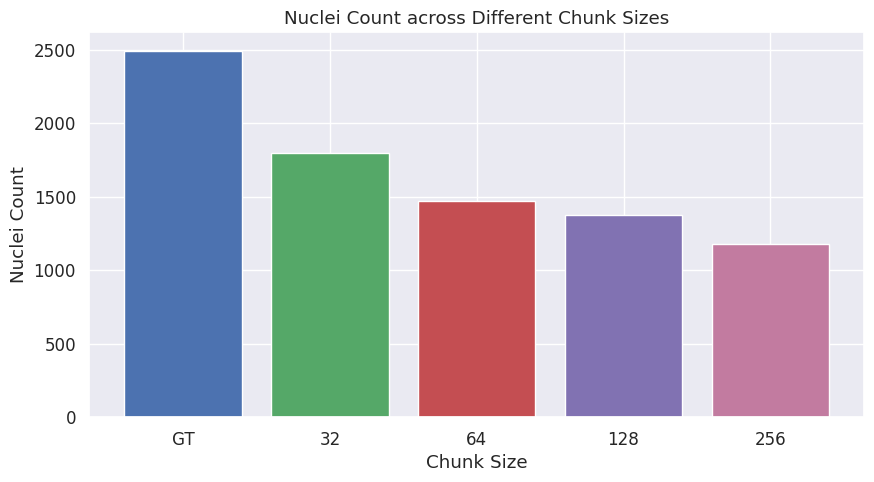

In [65]:
keys = list(metric_dict.keys())
values = list(metric_dict.values())

# Create bar plot
plt.figure(figsize=(10, 5))
plt.bar(keys, values, color=['#4c72b0', '#55a868', '#c44e52', '#8172b2', '#c27ba0'])
plt.xlabel('Chunk Size')
plt.ylabel('Nuclei Count')
plt.title('Nuclei Count across Different Chunk Sizes')
plt.show()

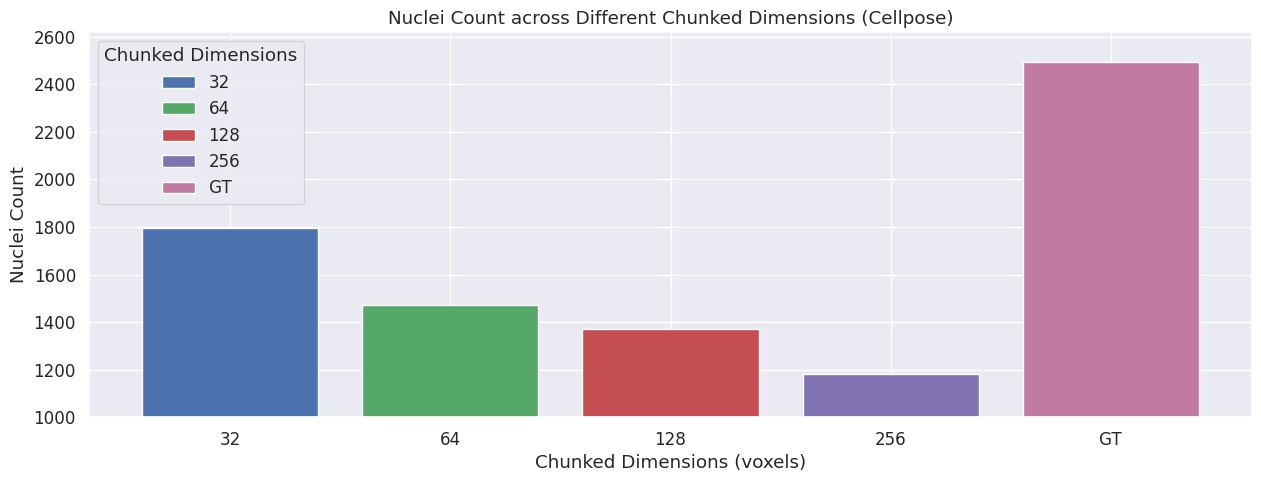

In [87]:
nuclei_count_cellpose = {'32': 1797, '64': 1471, '128': 1373, '256': 1180, 'GT': 2494}

# Extract keys and values
keys = list(nuclei_count_cellpose.keys())
values = list(nuclei_count_cellpose.values())

# Define custom colors
colors = ['#4c72b0', '#55a868', '#c44e52', '#8172b2', '#c27ba0']

# Create bar plot
plt.figure(figsize=(15, 5))
bars = plt.bar(keys, values, color=colors)

# Add a legend
plt.legend(bars, keys, title='Chunked Dimensions', loc='best')

plt.ylim(bottom=1000)
plt.xlabel('Chunked Dimensions (voxels)')
plt.ylabel('Nuclei Count')
plt.title('Nuclei Count across Different Chunked Dimensions (Cellpose)')
plt.savefig('cellpose-count.png')
plt.show()

In [70]:
for k, v in metric_dict.items():
    metric_dict[k] = v + 0.5

In [71]:
stitching_stats = StitchingAnalysis(
                metric_dict=metric_dict,
                metric_name='IoU',
                var_name="Chunk Size",
                save_path='./',
                resolution=300,
            )

In [72]:
all_stats, kruskal_result = stitching_stats.all_analysis()

/net/vast-storage/scratch/vast/gablab/ckapoor/lsm-segmentation/lsm/evaluation/plotting.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/net/vast-storage/scratch/vast/gablab/ckapoor/lsm-segmentation/lsm/evaluation/plotting.py:86: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x=self.var_name, y=self.metric_name, data=self.data, ci=None)


In [73]:
print(f"Descriptive statistics: {all_stats}")
print(f"Results from kruskal's h-test (p value): {kruskal_result:.3f}")

Descriptive statistics:          mean       std       var
IoU  0.755413  0.023575  0.000556
Results from kruskal's h-test (p value): 0.392


# mean geometry plots

In [4]:
from lsm.evaluation.segmentation_metrics import SegmentationMetrics

In [ ]:
gt_vol = imread('/om2/user/ckapoor/lsm-segmentation/model_analysis/stitching/anystar-spherical_seg/gt_proxy.tiff')
basedir = '/om2/user/ckapoor/lsm-segmentation/model_analysis/stitching/anystar-spherical_seg/'

chunks = [32, 64, 128, 256]
stitched_vols = [
        imread(os.path.join(basedir, f"chunk_{csize}.tiff")) for csize in chunks
    ]

In [15]:
#gt_vol = imread('/om2/user/ckapoor/lsm-segmentation/model_analysis/stitching/cellpose/gt_proxy.tiff')
basedir = '/om2/user/ckapoor/lsm-segmentation/lsm/models/'
imnames = {'cellpose': 'label_vol_cellpose.tiff', 
           'anystar': 'label_vol_anystar.tiff', 
           'anystar_gaussian': 'label_vol_gaussian.tiff', 
           'anystar_spherical': 'label_vol_spherical.tiff'}

vols = [imread(os.path.join(basedir, v)) for _, v in imnames.items()]

In [8]:
from skimage.measure import regionprops, regionprops_table, label

In [16]:
tabs = {}

for i, (k, _) in enumerate(imnames.items()):
    props = regionprops_table(vols[i], properties=(
                "area",
                "axis_major_length",
                # "axis_minor_length",
            ),
        )
    props_table = pd.DataFrame(props)
    tabs[k] = props_table

In [23]:
area_data = pd.concat([df[['area']].assign(Model=model) for model, df in tabs.items()])

In [25]:
axis_major_length_data = pd.concat([df[['axis_major_length']].assign(Model=model) for model, df in tabs.items()])

/tmp/ipykernel_1134177/444545190.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='area', data=area_data, palette=palette)


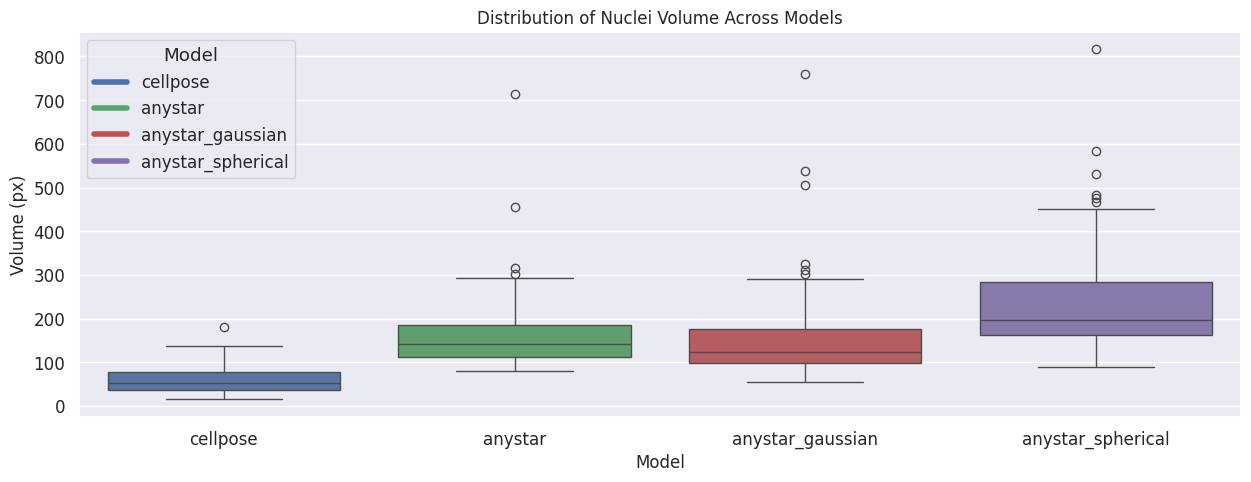

In [53]:
palette = ['#4c72b0', '#55a868', '#c44e52', '#8172b2']

plt.figure(figsize=(15, 5))
sns.set(font_scale=1.1)
sns.boxplot(x='Model', y='area', data=area_data, palette=palette)
plt.title('Distribution of Nuclei Volume Across Models', fontsize=12)
plt.legend(handles=[plt.Line2D([0], [0], color=palette[i], lw=4) for i in range(len(palette))],
           labels=tabs.keys(), title='Model')
plt.ylabel('Volume (px)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.savefig(f'nuclei-volume.png', dpi=300)
plt.show()

/tmp/ipykernel_1134177/30797443.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='axis_major_length', data=axis_major_length_data, palette=palette)


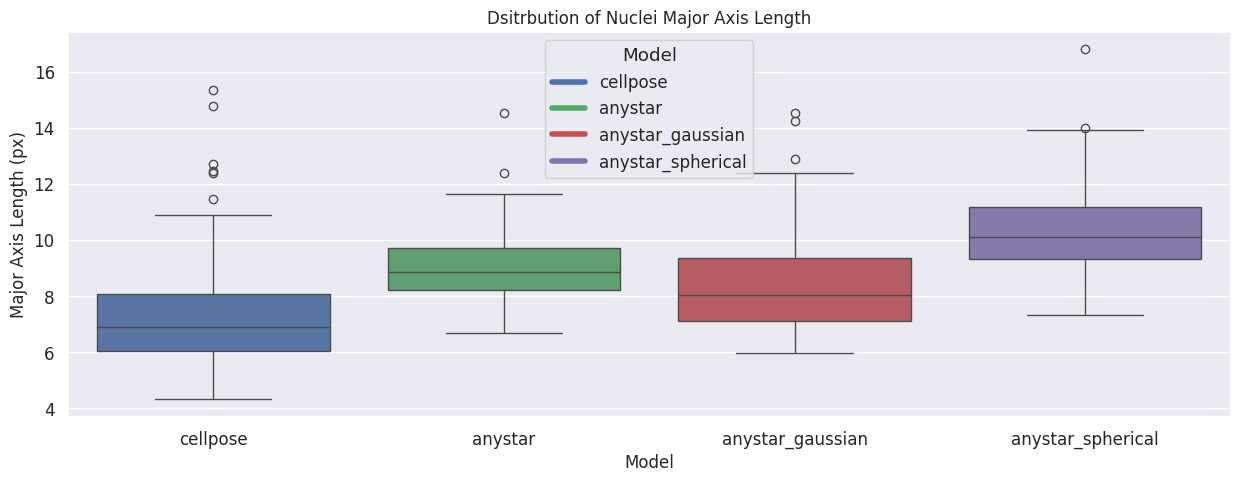

In [52]:
plt.figure(figsize=(15, 5))
sns.set(font_scale=1.1)
sns.boxplot(x='Model', y='axis_major_length', data=axis_major_length_data, palette=palette)
plt.title('Dsitrbution of Nuclei Major Axis Length', fontsize=12)
plt.legend(handles=[plt.Line2D([0], [0], color=palette[i], lw=4) for i in range(len(palette))],
           labels=tabs.keys(), title='Model')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Major Axis Length (px)', fontsize=12)
plt.savefig(f'nuclei-major-axis.png', dpi=300)
plt.show()

In [42]:
area_stats = area_data.groupby('Model')['area'].agg(['mean', 'std']).reset_index()

# Calculate mean and standard deviation for 'axis_major_length'
axis_major_length_stats = axis_major_length_data.groupby('Model')['axis_major_length'].agg(['mean', 'std']).reset_index()
